In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import History

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To train on vectors made of two decks 
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)

In [36]:
decks = pd.read_csv('decks.csv', index_col=0)
# All probabilities are already in decks.csv
# prob = pd.read_csv('prob.csv', index_col=0)

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
tsne_results = tsne.fit_transform(decks.iloc[:, 0:-5])

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.007s...
[t-SNE] Computed neighbors for 400 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.705503


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.960487


[t-SNE] Error after 1000 iterations: 0.144068


/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


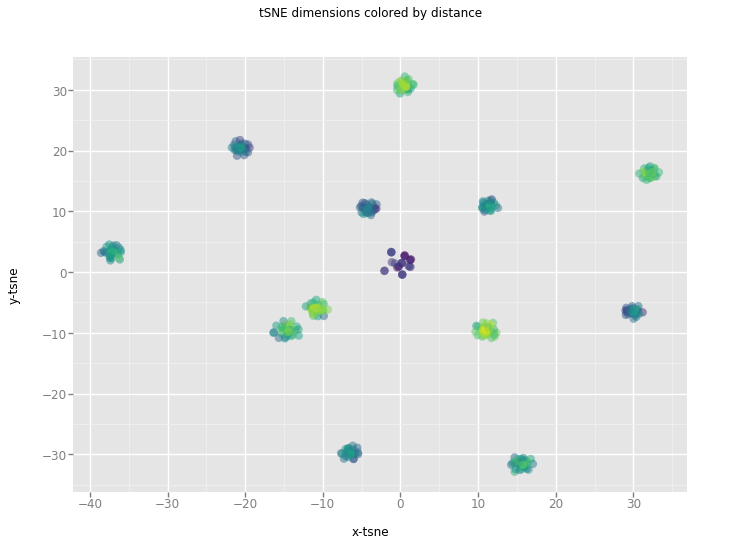

<ggplot: (8742412514217)>

In [6]:
%matplotlib inline
from ggplot import *

df_tsne = decks.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne')) \
        + geom_point(aes(colour='prob'), size=70, alpha=0.5) \
        + ggtitle("tSNE dimensions colored by distance")
chart

Preparing data:

In [30]:
def add_bot_dummies(old_data_set):
    """Returns new data set with 4 times more rows and dummies for four bots."""
    # Data set should not contain probabilities
    data_set = np.array(old_data_set, dtype=np.int)
    
    nrows = data_set.shape[0]
    
    data_set = np.append(data_set, data_set, axis=0)
    data_set = np.append(data_set, data_set, axis=0)
    
    bots = np.zeros((1600, 4), dtype=np.int)
    bots[0:nrows, 0] = 1
    bots[nrows:2*nrows, 1] = 1
    bots[2*nrows:3*nrows, 2] = 1
    bots[3*nrows:4*nrows, 3] = 1
    
    data_set = np.append(data_set, bots, axis=1)
    
    return data_set

In [56]:
X_train = add_bot_dummies(decks.iloc[:, 0:-5].copy())

In [57]:
def get_bots_prob(bots_prob):
    """"Given array of probabilities for four bots returns 2D array with 4 times more rows and 4 times less columns"""
    bot_1 = np.array(bots_prob.iloc[:, 0], dtype=np.float)
    bot_2 = np.array(bots_prob.iloc[:, 1], dtype=np.float)
    bot_3 = np.array(bots_prob.iloc[:, 2], dtype=np.float)
    bot_4 = np.array(bots_prob.iloc[:, 3], dtype=np.float)
    
    bots = np.append(bot_1, bot_2, axis=0)
    bots = np.append(bots, bot_3, axis=0)
    bots = np.append(bots, bot_4, axis=0)
    bots = np.expand_dims(bots, axis=1)
    
    return bots

In [58]:
y_train = get_bots_prob(decks.iloc[:, -4:].copy())

In [59]:
def shuffle_and_expand_dims(X_train, y_train):
    
    if X_train.shape[0] != y_train.shape[0]:
        print("Wrong input")
        print("Number of rows in X: " + str(X_train.shape[0]))
        print("Number of rows in y: " + str(y_train.shape[0]))
    
    temp = np.append(X_train, y_train, axis=1)
    np.random.shuffle(temp)
    X_train = temp[:, 0:-1]
    y_train = temp[:, -1]
    
    # Keras sequential needs input to have 3D and clases (and predictions) to have 2D
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=1)
    
    return X_train, y_train

In [60]:
X_train, y_train = shuffle_and_expand_dims(X_train, y_train)

In [62]:
print(X_train.shape)
print(y_train.shape)

(1600, 343, 1)
(1600, 1)


Creating model:

In [83]:
batch_size = 100
num_classes = 1
nepochs = 100
learning_rate = 0.03
decay_rate = learning_rate / nepochs

In [80]:
model = Sequential()

model.add(Conv1D(32, 3, padding='same', input_shape=(343, 1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.1))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

In [81]:
#opt = keras.optimizers.RMSprop(lr=0.2)
opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay=decay_rate, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

Training:

In [84]:
history = model.fit(X_big, y_big, batch_size=batch_size, epochs=nepochs)

Epoch 1/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 431us/step - loss: 0.0032 - acc: 0.0000e+00


Epoch 2/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 381us/step - loss: 0.0031 - acc: 0.0000e+00


Epoch 3/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 343us/step - loss: 0.0030 - acc: 0.0000e+00


Epoch 4/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 336us/step - loss: 0.0030 - acc: 0.0000e+00


Epoch 5/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 426us/step - loss: 0.0029 - acc: 0.0000e+00


Epoch 6/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 571us/step - loss: 0.0029 - acc: 0.0000e+00


Epoch 7/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 545us/step - loss: 0.0028 - acc: 0.0000e+00


Epoch 8/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 533us/step - loss: 0.0028 - acc: 0.0000e+00


Epoch 9/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0030 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 467us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 10/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 302us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 11/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 494us/step - loss: 0.0026 - acc: 0.0000e+00


Epoch 12/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 416us/step - loss: 0.0026 - acc: 0.0000e+00


Epoch 13/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 662us/step - loss: 0.0025 - acc: 0.0000e+00


Epoch 14/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0021 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 1s - loss: 0.0024 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 632us/step - loss: 0.0025 - acc: 0.0000e+00


Epoch 15/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0021 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 615us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 16/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 619us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 17/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 623us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 18/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 479us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 19/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 479us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 20/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 524us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 21/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 444us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 22/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 529us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 23/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 479us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 24/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 526us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 25/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 460us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 26/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 446us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 27/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 484us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 28/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0018 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0019 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 492us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 29/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 595us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 30/100


 100/1600 [>.............................] - ETA: 1s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 516us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 31/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 336us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 32/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 321us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 33/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 320us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 34/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 355us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 35/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 339us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 36/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 340us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 37/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 460us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 38/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 371us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 39/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 349us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 40/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 375us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 41/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 333us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 42/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 335us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 43/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 334us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 44/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 353us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 45/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 327us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 46/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 325us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 47/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 325us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 48/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 325us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 49/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 332us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 50/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 326us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 51/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 321us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 52/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 319us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 53/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 315us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 54/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 316us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 55/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 56/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 320us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 57/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 58/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 316us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 59/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 318us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 60/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 322us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 61/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 466us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 62/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 461us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 63/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 453us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 64/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 482us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 65/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 526us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 66/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 348us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 67/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 382us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 68/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 320us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 69/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 70/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 318us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 71/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 319us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 72/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 345us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 73/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 369us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 74/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 539us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 75/100


 100/1600 [>.............................] - ETA: 0s - loss: 9.7371e-04 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 9.5862e-04 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00    

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 501us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 76/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 489us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 77/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 489us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 78/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 479us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 79/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 538us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 80/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 380us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 81/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 347us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 82/100


 100/1600 [>.............................] - ETA: 0s - loss: 9.9883e-04 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00    

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 351us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 83/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 412us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 84/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 85/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 314us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 86/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 87/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 390us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 88/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 333us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 89/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 491us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 90/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 405us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 91/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 469us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 92/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 508us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 93/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 416us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 94/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 329us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 95/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 334us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 96/100


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 97/100
 100/1600 [>.............................] - ETA: 0s - loss: 9.9194e-04 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00    

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 314us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 98/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 316us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 99/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 100/100
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0012 - acc: 0.0000e+00


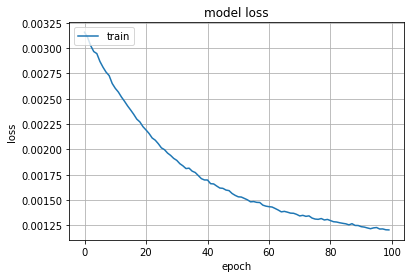

In [88]:
%matplotlib inline 
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.grid()
plt.legend(['train'], loc='upper left')
plt.title('model loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [126]:
def getResults():
    X_test = pd.read_csv("X_test.csv", index_col=0)
    X_test_big = np.array(X_test.copy(), dtype=float)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    
    bots = np.zeros((800, 4), dtype=np.int)
    bots[0:200, 0] = 1
    bots[200:400, 1] = 1
    bots[400:600, 2] = 1
    bots[600:800, 3] = 1
    
    X_test_big = np.append(X_test_big, bots, axis=1)
    X_test_big = np.expand_dims(X_test_big, axis=2)
    
    print(X_test_big.shape)
    
    y_test_big = model.predict_proba(X_test_big)
    
    print(y_test_big.shape)
    
    bots_list = ['A1'] * 200 + ['A2'] * 200 + ['B1'] * 200 + ['B2'] * 200
    output = pd.DataFrame(bots_list, columns=['bot'])
    output['deck'] = list(X_test.index) * 4
    output['prob'] = y_test_big
    
    def f(x):
        return x * 100
    
    output['prob'] = output['prob'].apply(f)
    print(output)
    
    output.to_csv('results.csv', sep=';', header=False, index=False)

In [127]:
getResults()

(800, 343, 1)
(800, 1)
    bot        deck       prob
0    A1  deck244804  32.680619
1    A1  deck124802  45.758259
2    A1  deck687350  45.166996
3    A1  deck517728  43.164873
4    A1  deck130762  43.599597
5    A1  deck322071  35.716188
6    A1  deck874296  57.761812
7    A1  deck206745  58.232880
8    A1  deck895482  70.217043
9    A1  deck160842  52.547753
10   A1  deck838916  40.504783
11   A1  deck780914  38.426331
12   A1  deck750047  41.368017
13   A1  deck652829  51.765013
14   A1  deck804465  44.209716
15   A1  deck527231  48.478863
16   A1  deck564938  46.845999
17   A1  deck960955  49.884540
18   A1  deck573326  53.278315
19   A1  deck197957  35.268238
20   A1  deck592549  50.844324
21   A1  deck590796  42.318362
22   A1  deck454901  41.531298
23   A1  deck224429  63.902456
24   A1  deck237007  43.033722
25   A1  deck679633  45.193341
26   A1  deck333404  42.955166
27   A1  deck865510  43.200415
28   A1  deck445345  36.288133
29   A1  deck331249  69.569367
..   ..         

In [3]:
print(X_test.shape)
print(X_test.head())

(200, 339)
            Abyssal Enforcer  Acherus Veteran  Acidic Swamp Ooze  \
deckName                                                           
deck244804                 0                0                  0   
deck124802                 0                0                  0   
deck687350                 0                0                  0   
deck517728                 0                0                  0   
deck130762                 0                0                  0   

            Acolyte of Agony  Acolyte of Pain  Al'Akir the Windlord  Alleycat  \
deckName                                                                        
deck244804                 0                1                     0         0   
deck124802                 0                2                     0         0   
deck687350                 0                1                     0         0   
deck517728                 0                2                     0         0   
deck130762                